<a href="https://colab.research.google.com/github/graphtrek/stockforecast/blob/main/graphtrek_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# install necessary modules
!pip install yfinance
!pip install plotly==5.2.1
!pip install ta
!pip install mplfinance

In [21]:
import pandas as pd
import yfinance as yf
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import requests
from bs4 import BeautifulSoup
import numpy as np
import math
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

In [59]:
ticker = yf.Ticker("TSLA")
ticker.splits
historical = ticker.history(start="2020-02-05", end="2020-02-25", interval="1d")
historical

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-02-05,823.260010,845.979980,704.110596,734.700012,48423837,0,0
2020-02-06,699.919983,795.830017,687.000000,748.960022,39880752,0,0
2020-02-07,730.549988,769.750000,730.000000,748.070007,17063521,0,0
2020-02-10,800.000000,819.989990,752.400024,771.280029,24689163,0,0
2020-02-11,768.789978,783.506104,758.000000,774.380005,11697473,0,0
2020-02-12,777.869995,789.750000,763.369995,767.289978,12022470,0,0
2020-02-13,741.840027,818.000000,735.000000,804.000000,26289348,0,0
2020-02-14,787.219971,812.969971,785.500000,800.030029,15693711,0,0
2020-02-18,168.320007,172.000000,166.472000,171.679993,83491845,0,0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 2020-01-02 to 2020-03-31
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          62 non-null     float64
 1   High          62 non-null     float64
 2   Low           62 non-null     float64
 3   Close         62 non-null     float64
 4   Volume        62 non-null     int64  
 5   Dividends     62 non-null     int64  
 6   Stock Splits  62 non-null     int64  
dtypes: float64(4), int64(3)
memory usage: 3.9 KB
None


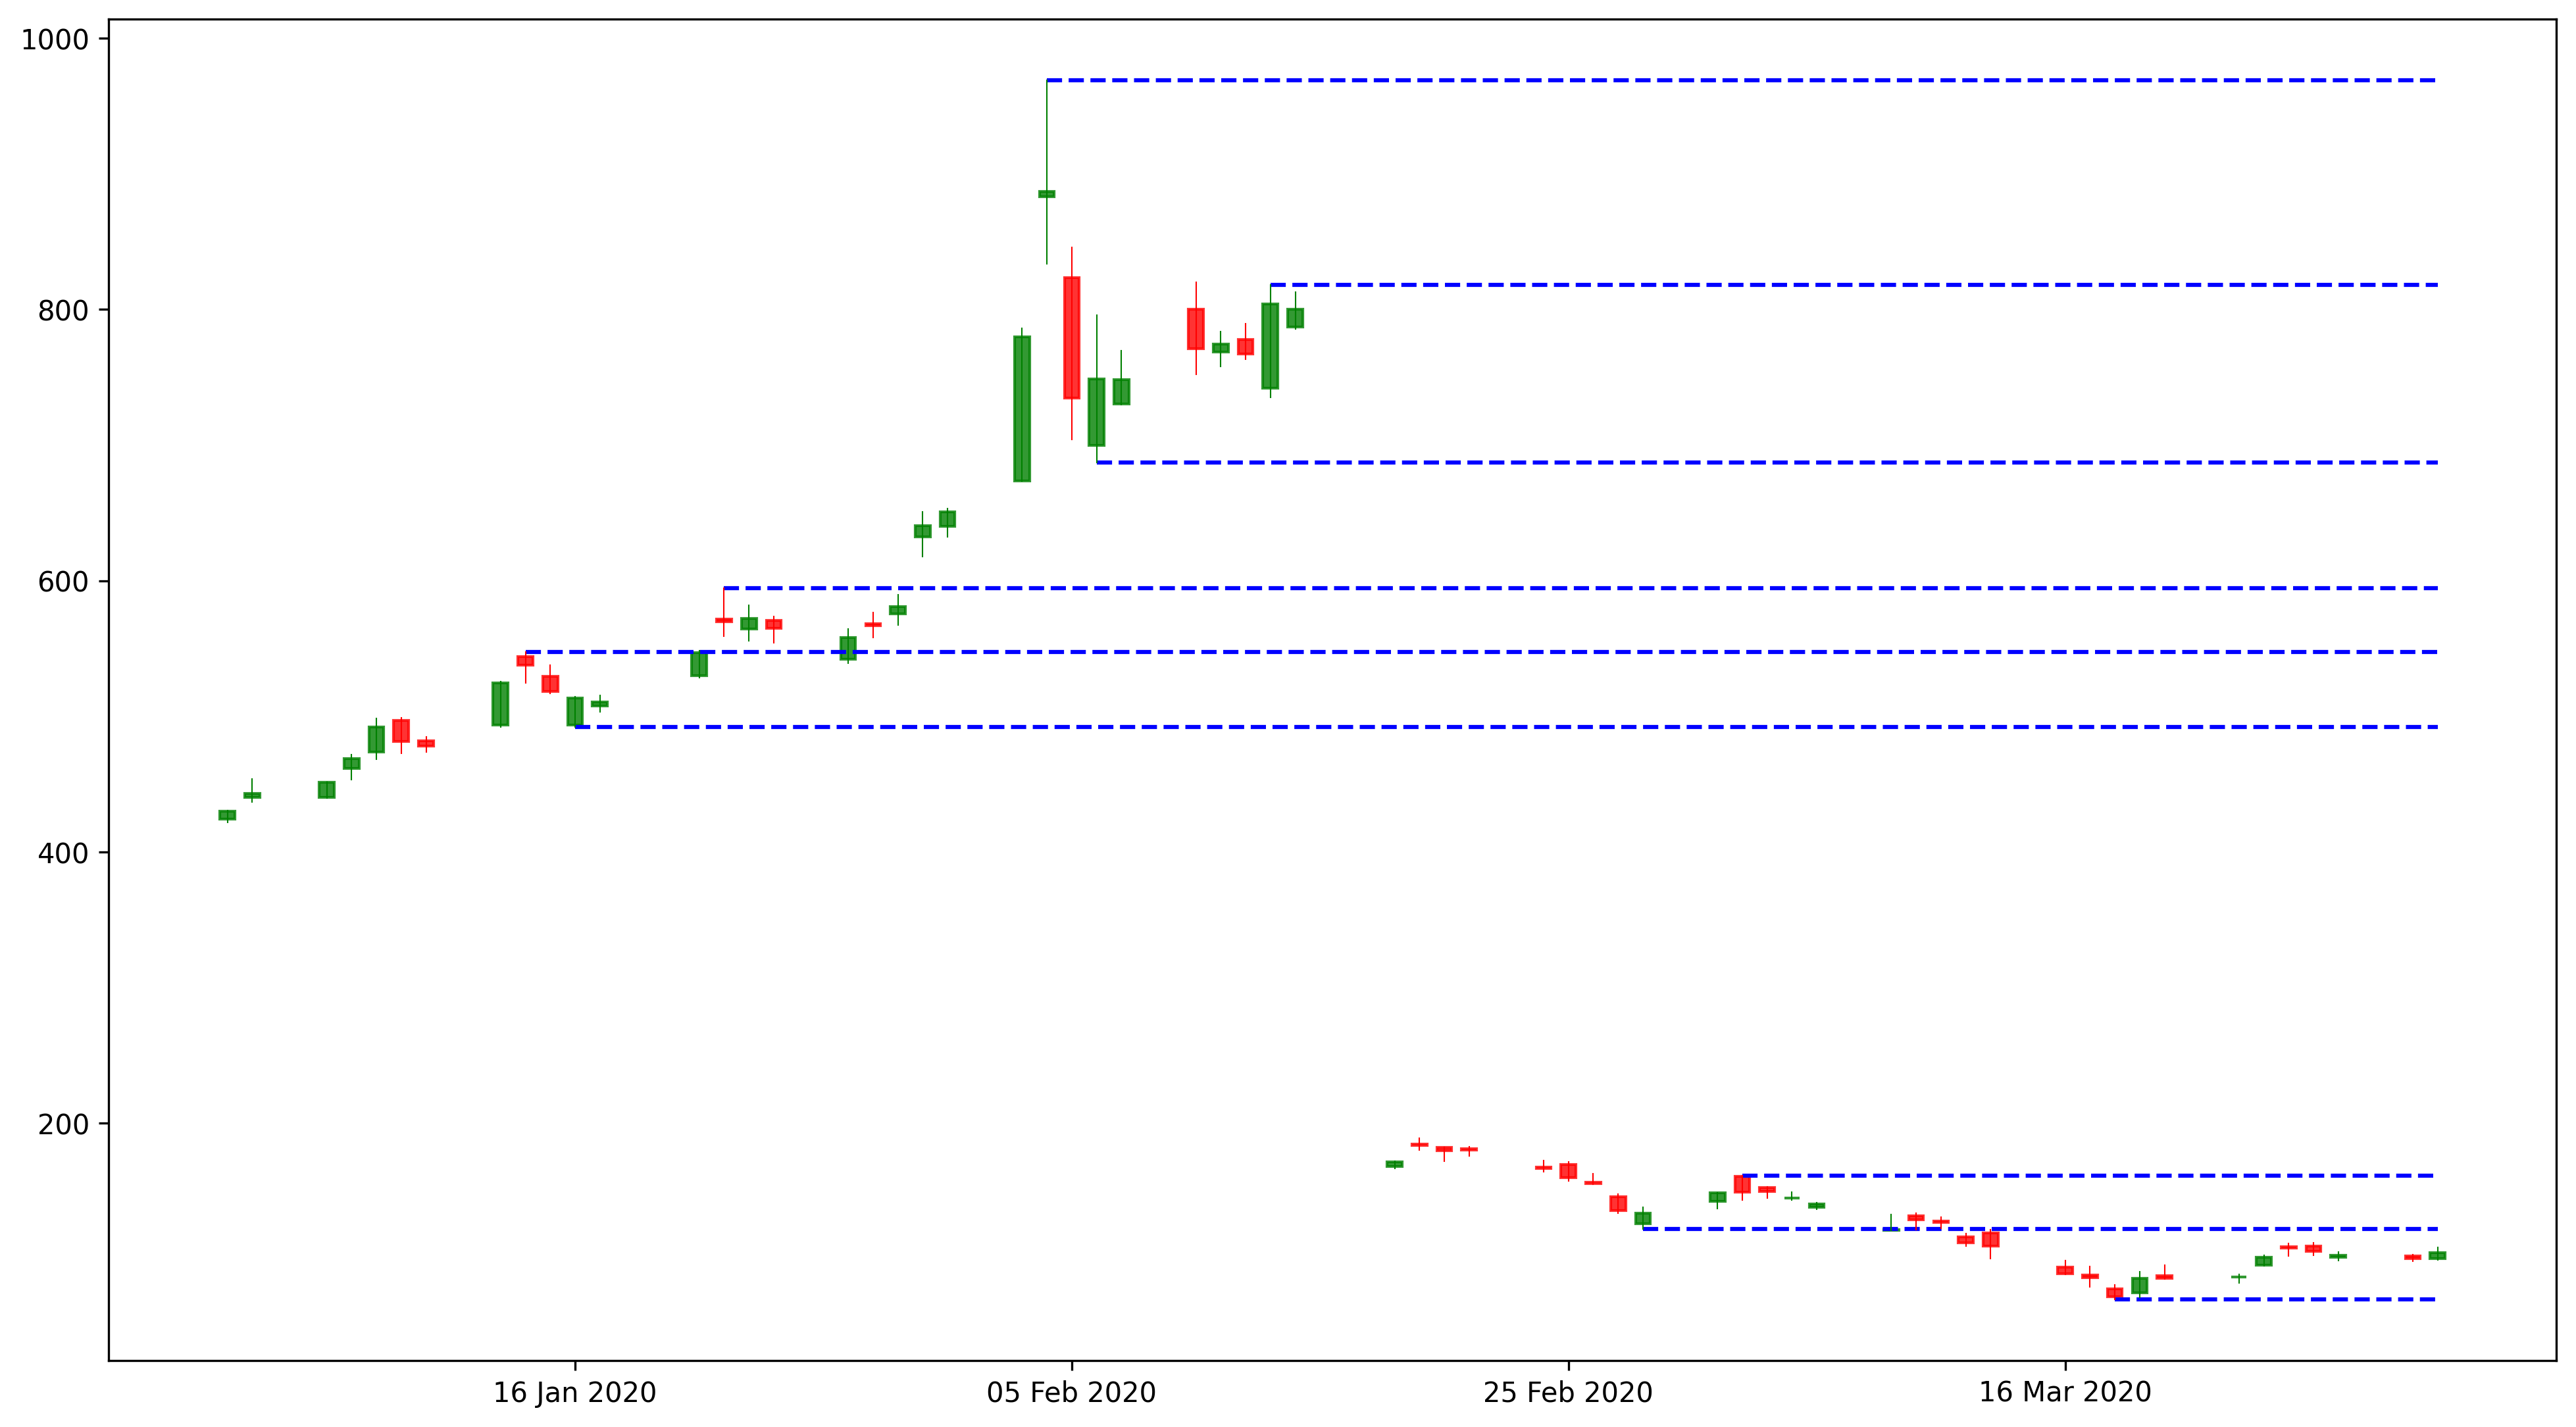

In [58]:
# method 1: fractal candlestick pattern

def get_stock_price(symbol):
  #df = yf.download(symbol, start='2020-01-01')
  #df = df.rename(columns={"Close": "Close1", "Adj Close": "Close"})
  
  ticker = yf.Ticker(symbol)
  #ticker.splits
  df = ticker.history(start="2020-02-05",end="2020-02-25", interval="1d")
  print(df.info())
  df['Date'] = pd.to_datetime(df.index)
  df['Date'] = df['Date'].apply(mpl_dates.date2num)
  df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
  return df

def is_support(df,i):
  cond1 = df['Low'][i] < df['Low'][i-1] 
  cond2 = df['Low'][i] < df['Low'][i+1] 
  cond3 = df['Low'][i+1] < df['Low'][i+2] 
  cond4 = df['Low'][i-1] < df['Low'][i-2]
  return (cond1 and cond2 and cond3 and cond4)

def is_resistance(df,i):
  cond1 = df['High'][i] > df['High'][i-1] 
  cond2 = df['High'][i] > df['High'][i+1] 
  cond3 = df['High'][i+1] > df['High'][i+2] 
  cond4 = df['High'][i-1] > df['High'][i-2]
  return (cond1 and cond2 and cond3 and cond4)

def is_far_from_level(value, levels, df):
    ave =  np.mean(df['High'] - df['Low'])
    return np.sum([abs(value - level) < ave for _, level in levels]) == 0

def plot_all(levels, df):
    fig, ax = plt.subplots(figsize=(16, 9), dpi=300)
    candlestick_ohlc(ax,df.values,width=0.6, colorup='green', colordown='red', alpha=0.8)
    date_format = mpl_dates.DateFormatter('%d %b %Y')
    ax.xaxis.set_major_formatter(date_format)
    for level in levels:
        plt.hlines(level[1], xmin=df['Date'][level[0]], xmax=max(df['Date']), colors='blue', linestyle='--')
    fig.show()

stock_code = 'TSLA'
df = get_stock_price(stock_code)
levels = []
for i in range(2,len(df)-2):
  if is_support(df,i):
    l = df['Low'][i]
    if is_far_from_level(l, levels, df):
      levels.append((i,l))
  elif is_resistance(df,i):
    l = df['High'][i]
    if is_far_from_level(l, levels, df):
      levels.append((i,l))

plot_all(levels, df)